# Quantum Process Tomography via Genetic Algorithms

## Single SU(2) Transformations
___

This notebook performs the process tomography for the numerical experiments proposed in our paper 'Retrieving complex polarization transformations via optimized quantum process tomography'.
 

   The notebook is organized as follows: 

   1. Importing the synthetic data
   2. Setting the hyper-parameters of the Genetic Algorithm
   3. Performing the genetic recostruction with 6 measurements
________

First, the required libraries are imported:

In [43]:
from deap import base
from deap import creator
from deap import tools
import numpy as np
import random
import math
import pandas as pd
import time
import matplotlib.pyplot as plt
import statistics
import utils.GA_utils as GA_utils

By running the following cell, you import the experimental data.


In [45]:
error = "5"
path = "dataset/"+ error

LL = np.loadtxt(path + "/LL.txt", dtype="f", delimiter="\t")
LH = np.loadtxt(path + "/LH.txt", dtype="f", delimiter="\t")
LD = np.loadtxt(path + "/LD.txt", dtype="f", delimiter="\t")
HL = np.loadtxt(path + "/HL.txt", dtype="f", delimiter="\t")
HH = np.loadtxt(path + "/HH.txt", dtype="f", delimiter="\t")
HD = np.loadtxt(path + "/HD.txt", dtype="f", delimiter="\t")

If available, you can import the theoretical $U_{Th}$ to compute the fidelity of the reconstructed process.

In [46]:
path = "dataset"
Theta_t = np.loadtxt(path + "/random_Theta.txt", dtype="f", delimiter="\t")
nx_t = np.loadtxt(path + "/random_nx.txt", dtype="f", delimiter="\t")
ny_t = np.loadtxt(path + "/random_ny.txt", dtype="f", delimiter="\t")
nz_t = np.loadtxt(path + "/random_nz.txt", dtype="f", delimiter="\t")

The function `compute_unitary` is used to compute the unitary $U$, given the parameters $\Theta\in[0,\pi]$ and $\mathbf{n}=(n_x,n_y,n_z)$ according to:

\begin{equation}
U=\begin{pmatrix}
\cos \Theta -i \sin \Theta \,n_z && -i\sin \Theta \,(n_x-i n_y)\\
-i\sin \Theta \,(n_x+i n_y) && \cos \Theta + i \sin \Theta \,n_z
\end{pmatrix}
\end{equation}

In [47]:
def compute_unitary(Theta, nx, ny, nz):
    I = np.array([[1, 0], [0, 1]])
    sx = np.matrix([[0, 1], [1, 0]])
    sy = np.matrix([[0, -1j], [1j, 0]])
    sz = np.matrix([[1, 0], [0, -1]])
    return math.cos(Theta) * I - 1j * math.sin(Theta) * (nx * sx + ny * sy + nz * sz)

_____

### Polarimetric measurements

We provide the explicit expression of possible polarimetric measurements in terms of the parameters $\Theta$ and $\mathbf{n}$

In [48]:
def lltheory(Theta,nx,ny,nz):
    return math.cos(Theta)**2 + nz**2 * math.sin(Theta)**2
def lhtheory(Theta,nx,ny,nz):
    return 0.5 * (1 + 2 * nx * nz * math.sin(Theta)**2 + ny * math.sin(2 * Theta))
def ldtheory(Theta,nx,ny,nz):
    return 0.5 - nx * math.cos(Theta) * math.sin(Theta) + ny * nz * math.sin(Theta)**2
def hltheory(Theta,nx,ny,nz):
    return 0.5 - ny * math.cos(Theta) * math.sin(Theta) + nx * nz * math.sin(Theta)**2
def hhtheory(Theta,nx,ny,nz):
    return math.cos(Theta)**2 + nx**2 * math.sin(Theta)**2
def hdtheory(Theta,nx,ny,nz):
    return 0.5 * (1 + 2 * nx * ny * math.sin(Theta)**2 + nz * math.sin(2 * Theta))

The hyper-parameters of the GA are defined:

In [49]:
POP_SIZE = 40
CXPB = 0.8
MUTPB = 0.1
NGEN = 60
STATS = GA_utils.createStats()
pop_list = None
TS_SIZE = 3

_____

### Genetic Reconstruction with 6 measurements

The following cell defines the fitness function to perform the genetic reconstruction with 6 measurements. 
The set of measurements is  $[HH, LL, HL, LD, LH, HD]$

In [50]:
def evaluate(HH, LL, HL, LD, LH, HD, individual):
    '''
    Fitness function for genetic reconstruction with 6 measurements
    _____
    
    :return The fitness value of an individual
    '''
    
    
    Theta, nx, ny, nz = individual[0], individual[1], individual[2], individual[3]
    ll = lltheory(Theta,nx,ny,nz)
    lh = lhtheory(Theta,nx,ny,nz)
    ld = ldtheory(Theta,nx,ny,nz)
    hl = hltheory(Theta,nx,ny,nz)
    hh = hhtheory(Theta,nx,ny,nz)
    hd = hdtheory(Theta,nx,ny,nz)

    f = ((ll - LL)**2) + ((lh - LH)**2) + ((ld - LD)**2) + ((hl - HL)**2) + ((hh - HH)**2) + ((hd - HD)**2)
    return f

The reconstruction starts. Specify in  `iteration` the number of independent runs to compute. Please, specify also the  `number_of_processes` you have to reconstruct, depending on the size of your dataset. 

In [51]:
# Create the DEAP toolbox
toolbox = GA_utils.createToolbox()
toolbox.decorate("mutate", GA_utils.checkBounds(0, np.pi))
toolbox.decorate("mate", GA_utils.checkBounds(0, np.pi))

# Set the number of iterations used for averaging the GA results
iterations = 10

#Specify the number of process you have to reconstruct
number_of_processes = 1000

# Reconstruction
F_to_average = []
for _ in range(iterations):
    best, times = [], []
    fidelities = []
    for i in range(number_of_processes):

        toolbox.register("evaluate", evaluate, HH[i], LL[i], HL[i], LD[i], LH[i], HD[i])

        GA = GA_utils.updatedGA(
            toolbox,
            pop_size=POP_SIZE,
            cxpb=CXPB,
            mutpb=MUTPB,
            ngen=NGEN,
            stats=STATS,
            tourn_size=TS_SIZE,
            hof=tools.HallOfFame(1),
            verbose=False,
        )
        best.append(GA[2][0])

        individual = GA[2][0]
        Theta = individual[0]
        nx = individual[1]
        ny = individual[2]
        nz = individual[3]

        computed_u = compute_unitary(Theta, nx, ny, nz)
        data_u = compute_unitary(Theta_t[i], nx_t[i], ny_t[i], nz_t[i])

        F = 0.5 * np.linalg.norm(np.trace(data_u.getH() * computed_u))
        fidelities.append(F)
    F_to_average.append(fidelities)

# Averaging of results
avg = []
for process in range(number_of_processes):
    fid = []
    for _ in range(iterations):
        fid.append(F_to_average[_][process])
    avg.append(statistics.mean(fid))


The fidelities of individual reconstructions is shown:

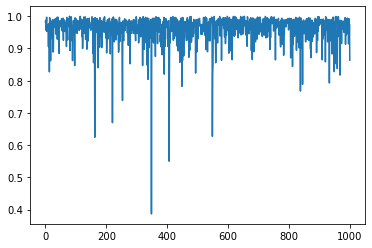

In [52]:
plt.plot(range(number_of_processes), avg)
plt.show()

The mean infidelity is computed:

In [53]:
print(
    statistics.mean([1 - avg[i] for i in range(len(avg))]),
    statistics.stdev([1 - avg[i] for i in range(len(avg))]),
)

0.039630882838170144 0.04635494090363773


In [54]:
np.max(avg)

0.999829185509027

In [55]:
np.savetxt("GA//fidelity_6_"+error+".txt",avg)